### Aim:
1.  Analyse what are the significant features related to cardiovascular diseases
2.  Suggest a model that can classify and make predictions on whether an individual is susceptible to cardiovascular diseases

In [ ]:
library(psych)
library(dplyr)
library(corrplot)
library(caret)
library(rpart)
library(rpart.plot)
library(e1071)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


corrplot 0.92 loaded

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following objects are masked from ‘package:psych’:

    %+%, alpha


Loading required package: lattice



First, import and inspect the data set.

In [ ]:
cardio <- read.csv("cardio_train.csv", sep = ";")
head(cardio)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,18393,2,168,62,110,80,1,1,0,0,1,0
2,1,20228,1,156,85,140,90,3,1,0,0,1,1
3,2,18857,1,165,64,130,70,3,1,0,0,0,1
4,3,17623,2,169,82,150,100,1,1,0,0,1,1
5,4,17474,1,156,56,100,60,1,1,0,0,0,0
6,8,21914,1,151,67,120,80,2,2,0,0,0,0


In [ ]:
describe(cardio)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
id,1,70000,4.997242e+04,2.885130e+04,50001.5,4.997651e+04,36981.9744,0,99999,99999,-0.001277758,-1.1984252,1.090477e+02
age,2,70000,1.946887e+04,2.467252e+03,19703.0,1.956932e+04,2536.7286,10798,23713,12915,-0.307042236,-0.8235359,9.325335e+00
gender,3,70000,1.349571e+00,4.768380e-01,1.0,1.311964e+00,0.0000,1,2,1,0.630933011,-1.6019464,1.802278e-03
height,4,70000,1.643592e+02,8.210126e+00,165.0,1.643226e+02,7.4130,55,250,195,-0.642159930,7.9426868,3.103136e-02
weight,5,70000,7.420569e+01,1.439576e+01,72.0,7.310963e+01,11.8608,10,200,190,1.012026734,2.5863954,5.441085e-02
ap_hi,6,70000,1.288173e+02,1.540114e+02,120.0,1.256049e+02,14.8260,-150,16020,16170,85.292558338,7579.3165867,5.821084e-01
ap_lo,7,70000,9.663041e+01,1.884725e+02,80.0,8.127688e+01,1.4826,-70,11000,11070,32.112706530,1425.7718273,7.123592e-01
cholesterol,8,70000,1.366871e+00,6.802503e-01,1.0,1.208589e+00,0.0000,1,3,2,1.587055377,0.9936307,2.571105e-03
gluc,9,70000,1.226457e+00,5.722703e-01,1.0,1.062875e+00,0.0000,1,3,2,2.397359064,4.2937764,2.162978e-03


The dataset contains 70,000 records of patient data. It includes a target variable "cardio" and 11 features that are objective basic health measurements, such as age, gender, height, weight etc. The result of the general desciptive analytics suggests that some data cleaning work is required so as to produce more accurate and more reliable analysis.

**Data Preparation**

1.Remove the id column

In [ ]:
cardio1 <- cardio[, 2:13]
head(cardio1)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,18393,2,168,62,110,80,1,1,0,0,1,0
2,20228,1,156,85,140,90,3,1,0,0,1,1
3,18857,1,165,64,130,70,3,1,0,0,0,1
4,17623,2,169,82,150,100,1,1,0,0,1,1
5,17474,1,156,56,100,60,1,1,0,0,0,0
6,21914,1,151,67,120,80,2,2,0,0,0,0


2.Remove the rows with systolic blood pressure lower than diastolic blood pressure i.e. ap_hi < ap_lo

In [ ]:
ap_cleaned <- cardio1 %>% filter(cardio1$ap_hi > cardio1$ap_lo)

3.Remove the anomalies

Anomalies and entries with unreasonable values are removed from the original dataset: extreme weight and height values, as well as extreme diastolic and systolic blood pressure values

In [ ]:
height_cleaned <- ap_cleaned %>% filter(ap_cleaned$height >= 140 & ap_cleaned$height <= 220)
weight_cleaned <- height_cleaned %>% filter(height_cleaned$weight >= 30)
ap_cleaned2 <- weight_cleaned %>% filter(weight_cleaned$ap_lo >= 30 & weight_cleaned$ap_lo <= 170)
cleaned_cardio <- ap_cleaned2 %>% filter(ap_cleaned2$ap_hi >= 70 & ap_cleaned2$ap_hi < 250)

head(cleaned_cardio)
summary(cleaned_cardio)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,18393,2,168,62,110,80,1,1,0,0,1,0
2,20228,1,156,85,140,90,3,1,0,0,1,1
3,18857,1,165,64,130,70,3,1,0,0,0,1
4,17623,2,169,82,150,100,1,1,0,0,1,1
5,17474,1,156,56,100,60,1,1,0,0,0,0
6,21914,1,151,67,120,80,2,2,0,0,0,0


      age            gender          height          weight      
 Min.   :10798   Min.   :1.000   Min.   :140.0   Min.   : 30.00  
 1st Qu.:17658   1st Qu.:1.000   1st Qu.:159.0   1st Qu.: 65.00  
 Median :19701   Median :1.000   Median :165.0   Median : 72.00  
 Mean   :19465   Mean   :1.349   Mean   :164.5   Mean   : 74.12  
 3rd Qu.:21324   3rd Qu.:2.000   3rd Qu.:170.0   3rd Qu.: 82.00  
 Max.   :23713   Max.   :2.000   Max.   :207.0   Max.   :200.00  
     ap_hi           ap_lo        cholesterol         gluc      
 Min.   : 70.0   Min.   : 30.0   Min.   :1.000   Min.   :1.000  
 1st Qu.:120.0   1st Qu.: 80.0   1st Qu.:1.000   1st Qu.:1.000  
 Median :120.0   Median : 80.0   Median :1.000   Median :1.000  
 Mean   :126.7   Mean   : 81.3   Mean   :1.365   Mean   :1.226  
 3rd Qu.:140.0   3rd Qu.: 90.0   3rd Qu.:2.000   3rd Qu.:1.000  
 Max.   :240.0   Max.   :170.0   Max.   :3.000   Max.   :3.000  
     smoke              alco             active           cardio      
 Min.   :0.0

4.Make categorical variables

Some categorical variables such as "cardio", "active", "alcohol" are treated as continuous variables in the original dataset. Thus, we need to make these variables categorical.

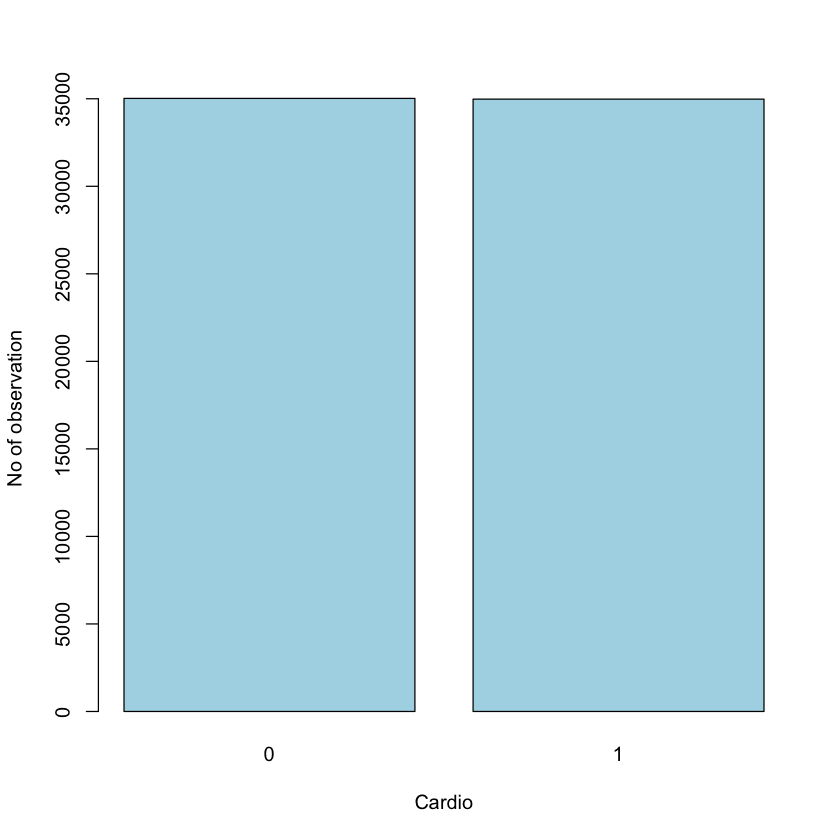

In [ ]:
plot(factor(cardio$cardio) ,col = "light blue", xlab = 'Cardio' , ylab = 'No of observation')
yes_indices = which(cardio$cardio == 1)
no_indices = which(cardio$cardio == 0)

In [ ]:
cols = c("gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio")
cleaned_cardio[cols] = lapply(cleaned_cardio[cols], factor)
summary(cleaned_cardio)

      age        gender        height          weight           ap_hi      
 Min.   :10798   1:44626   Min.   :140.0   Min.   : 30.00   Min.   : 70.0  
 1st Qu.:17658   2:23895   1st Qu.:159.0   1st Qu.: 65.00   1st Qu.:120.0  
 Median :19701             Median :165.0   Median : 72.00   Median :120.0  
 Mean   :19465             Mean   :164.5   Mean   : 74.12   Mean   :126.7  
 3rd Qu.:21324             3rd Qu.:170.0   3rd Qu.: 82.00   3rd Qu.:140.0  
 Max.   :23713             Max.   :207.0   Max.   :200.00   Max.   :240.0  
     ap_lo       cholesterol gluc      smoke     alco      active    cardio   
 Min.   : 30.0   1:51379     1:58258   0:62490   0:64863   0:13466   0:34619  
 1st Qu.: 80.0   2: 9283     2: 5057   1: 6031   1: 3658   1:55055   1:33902  
 Median : 80.0   3: 7859     3: 5206                                          
 Mean   : 81.3                                                                
 3rd Qu.: 90.0                                                           

5.Split the data

For the feasibility and accuracy of analysis, we select 10000 records out of the cleaned dataset using simple random sampling and split the data into the training set, validation set and test set according to the 70:15:15 partition. The training set is to fit the model; the validation set is to fine-tune the model hyperparameters and combat overfitting; the test set is to evaluate the model performances based on some indicators, such as accuracy and precision.

In [ ]:
set.seed(1)
data <- sample_n(cleaned_cardio, 10000)
idx <- sample(seq(1, 3), size = nrow(data), replace = TRUE, prob = c(.7, .15, .15))
train <- data[idx == 1,]
test <- data[idx == 2,]
valid <- data[idx == 3,]

In [ ]:
cols = c("gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio")
train[cols] = lapply(train[cols], factor)
test[cols] = lapply(test[cols], factor)
valid[cols] = lapply(valid[cols], factor)

**Exploratory Data Analytics on the Training Data**

1.Summary statistics

In [ ]:
summary(train)

      age        gender       height          weight           ap_hi      
 Min.   :10964   1:4527   Min.   :140.0   Min.   : 30.00   Min.   : 80.0  
 1st Qu.:17720   2:2454   1st Qu.:159.0   1st Qu.: 65.00   1st Qu.:120.0  
 Median :19703            Median :165.0   Median : 72.00   Median :120.0  
 Mean   :19487            Mean   :164.5   Mean   : 74.23   Mean   :126.7  
 3rd Qu.:21346            3rd Qu.:170.0   3rd Qu.: 82.00   3rd Qu.:140.0  
 Max.   :23677            Max.   :198.0   Max.   :183.00   Max.   :240.0  
     ap_lo        cholesterol gluc     smoke    alco     active   cardio  
 Min.   : 45.00   1:5272      1:5916   0:6341   0:6572   0:1359   0:3506  
 1st Qu.: 80.00   2: 947      2: 532   1: 640   1: 409   1:5622   1:3475  
 Median : 80.00   3: 762      3: 533                                      
 Mean   : 81.32                                                           
 3rd Qu.: 90.00                                                           
 Max.   :130.00          

4524 observations are females (gender = 1) and 2489 are males (gender = 2). There is a significant difference in the number of observations between gender. Thus, the data may be slightly biased due to the unequal distribution of gender.

3442 observations are not having cardiovascular diseases and the other 3491 observations suffer from cardiovascular diseases. The approximate ratio is 1:1 which suggests that the dependent variable “cardio” is distributed evenly, and accuracy is thus a reliable method to evaluate how a model performs.

3.Scatter plots and correlation plot

Scatter plots and correlation plots can visualise and roughly identify the possible correlation between any two continuous variables.

,age,height,weight,ap_hi,ap_lo
age,1.00000000,-0.08950103,0.07012436,0.20752037,0.1546900
height,-0.08950103,1.00000000,0.33020670,0.02785009,0.0458291
weight,0.07012436,0.33020670,1.00000000,0.27861867,0.2649363
ap_hi,0.20752037,0.02785009,0.27861867,1.00000000,0.7403429
ap_lo,0.15468999,0.04582910,0.26493630,0.74034288,1.0000000


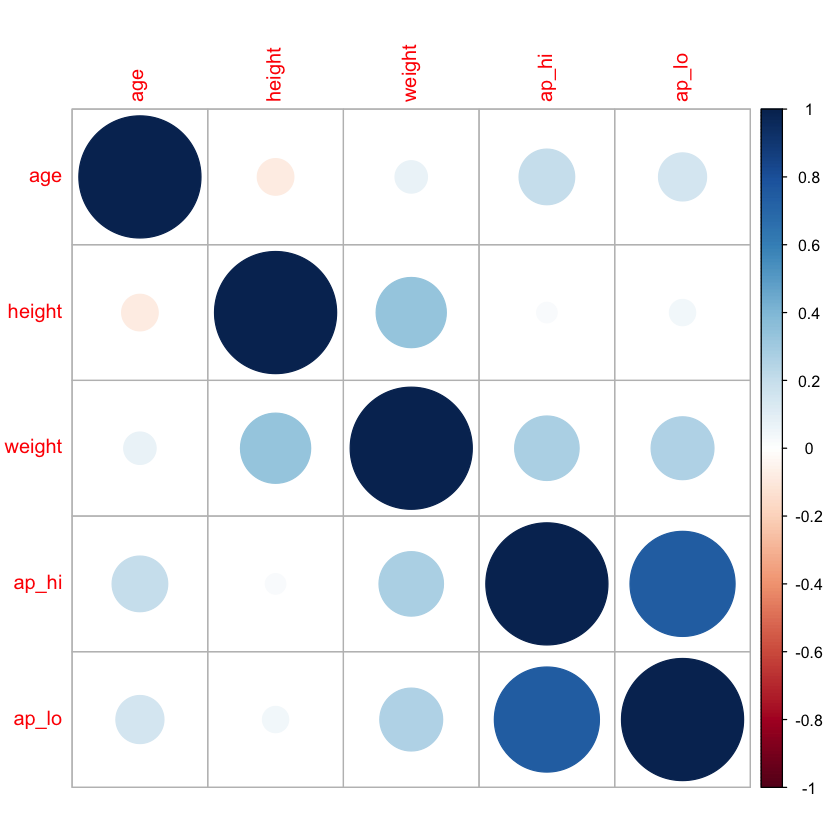

In [ ]:
train.corr <- cor(train[, c(1, 3, 4, 5, 6)])
train.corr
corrplot(train.corr, method = "circle")

From the above graphs, there are correlations between two pairs of continuous variables: ap_hi and ap_low, height and weight. The rest have very low correlation coefficient.

### Hypothesis Testing

**Hypothesis 1:** Do people with different cholesterol levels have different values of mean weight? Are cholesterol and weight correlated?


	One-way analysis of means

data:  train$weight and train$cholesterol
F = 59.601, num df = 2, denom df = 6978, p-value < 2.2e-16


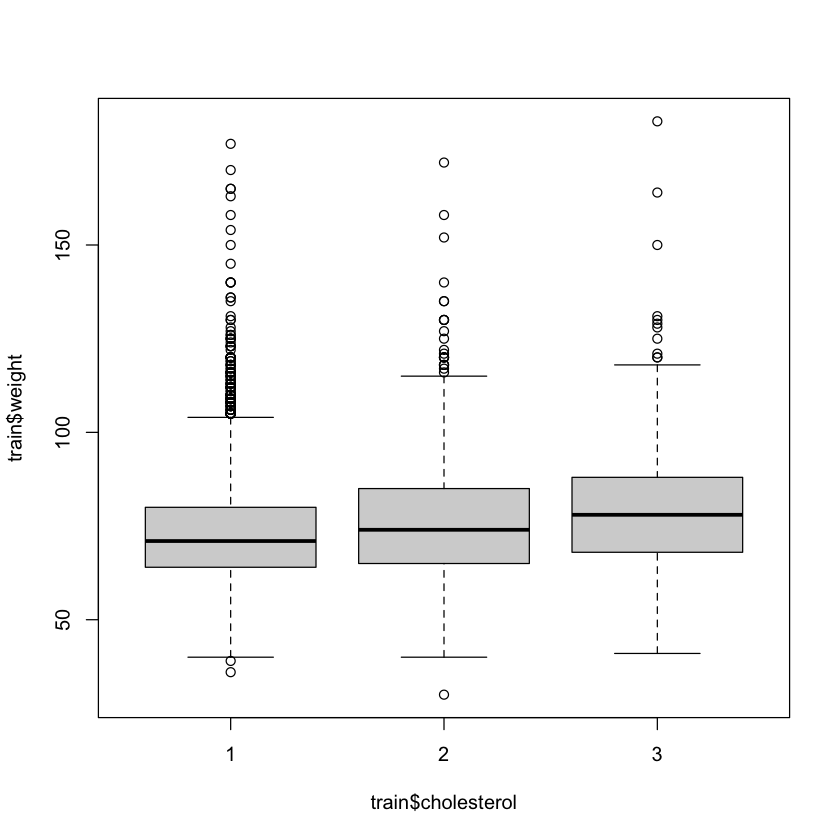

In [ ]:
oneway.test(train$weight~train$cholesterol, var.equal = TRUE)
boxplot(train$weight~train$cholesterol)

The null hypothesis is that the mean weight for people having different cholesterol levels is the same. Since the p-value is < 2.2e-16, which is smaller than 0.05. We reject the null hypothesis and conclude that there is a difference in the mean weight among people with various cholesterol levels. Also, from the box plots, we can see that median, upper and lower quartile all increase as cholesterol level rises from 1 (normal) to 3 (well above normal). This implies that independent variables of cholesterol and weight are positively correlated.

**Hypothesis 2:** Is there a correlation between independent variables height and weight?

In [ ]:
corr.test(train$height, train$weight)

Call:corr.test(x = train$height, y = train$weight)
Correlation matrix 
[1] 0.33
Sample Size 
[1] 6981
These are the unadjusted probability values.
  The probability values  adjusted for multiple tests are in the p.adj object. 
[1] 0

 To see confidence intervals of the correlations, print with the short=FALSE option

The correlation coefficient between height and weight is 0.31. Hence, the two variables are
moderately correlated. We decide to include a new independent variable Body Mass Index
2 (BMI) to substitute independent variables height and weight, where BMI = weight/(height^2).

**Hypothesis 3:** Are systolic blood pressure (ap_high) and diastolic blood pressure (ap_low) correlated?

In [ ]:
corr.test(train$ap_hi, train$ap_lo)

Call:corr.test(x = train$ap_hi, y = train$ap_lo)
Correlation matrix 
[1] 0.74
Sample Size 
[1] 6981
These are the unadjusted probability values.
  The probability values  adjusted for multiple tests are in the p.adj object. 
[1] 0

 To see confidence intervals of the correlations, print with the short=FALSE option

By applying the correlation test, the correlation coefficient between systolic blood pressure (ap_hi) and diastolic blood pressure (ap_lo) is 0.74, indicating a strong correlation between these two variables. Thus, interaction term ap_hi * ap_lo should be included in the model.

**Hypothesis 4:** Is gender independent of someone’s smoking habit?

   
       0    1
  1 4442   85
  2 1899  555


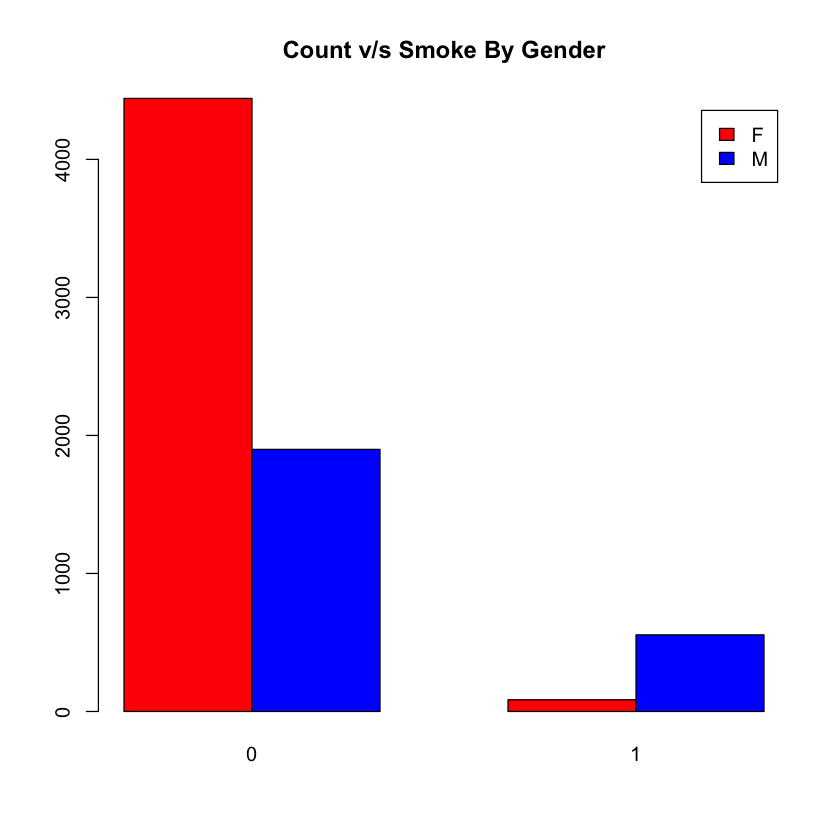

In [ ]:
my_table<-table(train$gender, train$smoke)
print(my_table)
barplot(my_table,main='Count v/s Smoke By Gender', col=c('red','blue'),names.arg=c(0,1), beside=T,legend=c('F','M'))

In [ ]:
chisq.test(train$gender, train$smoke, correct=FALSE)


	Pearson's Chi-squared test

data:  train$gender and train$smoke
X-squared = 821.9, df = 1, p-value < 2.2e-16


By conducting a Chi-Square test with a contingency table, the above result is obtained. The null hypothesis for the Chi-Square test is that the variables are independent of one another while the alternative hypothesis is that they are correlated in some way. The p-value is less than 2.2e-16, which is smaller than 0.05. There is sufficient evidence at 5% significance level to reject the null hypothesis and conclude that there is a correlation between gender and smoke.

**Variable Transformation and Selection**

1.Transform age in days to age in years[](http://)

In [ ]:
train$age_y <- NA
train$age_y <- train$age / 365

test$age_y <- NA
test$age_y <- test$age / 365

valid$age_y <- NA
valid$age_y <- valid$age / 365

2.Introduce a new term BMI to replace variables weight and height

In [ ]:
train$BMI <- NA
train$BMI <- (train$weight/ ((train$height/100)^2))

test$BMI <- NA
test$BMI <- (test$weight/ ((test$height/100)^2))

valid$BMI <- NA
valid$BMI <- (valid$weight/ ((valid$height/100)^2))

3.Include interaction terms

* Gender and smoke are correlated. Thus, an interaction term gender * smoke should be included.
* Systolic blood pressure and diastolic blood pressureare are strongly correlated. Hence, an interaction term ap_lo * ap_high should be included.
* Cholesterol and weight are correlated. Therefore, an interaction term cholesterol * BMI should be included.

4.Model selection using backwards stepwise selection

Subsequently, backwards stepwise selection is done to select variables which give the best performing model. Backward stepwise regression starts with a full model with all the independent variables included. At each step, it eliminates the worst-performing predictor until all the regressors left perform well. The worst-performing predictor to be removed in each step is determined by comparing pairwise with all models with one variable removed using F-test results. The outcome of the variable selection is shown below.

In [ ]:
full_model <- glm(cardio~age_y + gender + BMI + ap_hi + ap_lo + cholesterol + gluc + smoke + alco + active + (ap_hi*ap_lo) + (gender*smoke) + (cholesterol * BMI), data = train, family = "binomial")
step(full_model, direction="backward")

Start:  AIC=7877.74
cardio ~ age_y + gender + BMI + ap_hi + ap_lo + cholesterol + 
    gluc + smoke + alco + active + (ap_hi * ap_lo) + (gender * 
    smoke) + (cholesterol * BMI)

                  Df Deviance    AIC
- alco             1   7843.7 7875.7
- gender:smoke     1   7843.8 7875.8
- ap_hi:ap_lo      1   7844.0 7876.0
<none>                 7843.7 7877.7
- gluc             2   7848.2 7878.2
- BMI:cholesterol  2   7850.3 7880.3
- active           1   7851.2 7883.2
- age_y            1   8012.6 8044.6

Step:  AIC=7875.74
cardio ~ age_y + gender + BMI + ap_hi + ap_lo + cholesterol + 
    gluc + smoke + active + ap_hi:ap_lo + gender:smoke + BMI:cholesterol

                  Df Deviance    AIC
- gender:smoke     1   7843.8 7873.8
- ap_hi:ap_lo      1   7844.0 7874.0
<none>                 7843.7 7875.7
- gluc             2   7848.2 7876.2
- BMI:cholesterol  2   7850.3 7878.3
- active           1   7851.2 7881.2
- age_y            1   8012.7 8042.7

Step:  AIC=7873.76
cardio ~ age_


Call:  glm(formula = cardio ~ age_y + BMI + ap_hi + ap_lo + cholesterol + 
    gluc + active + BMI:cholesterol, family = "binomial", data = train)

Coefficients:
     (Intercept)             age_y               BMI             ap_hi  
       -11.76135           0.05508           0.02713           0.05490  
           ap_lo      cholesterol2      cholesterol3             gluc2  
         0.01469           0.97665           1.98664           0.10607  
           gluc3           active1  BMI:cholesterol2  BMI:cholesterol3  
        -0.21969          -0.19227          -0.02697          -0.03616  

Degrees of Freedom: 6980 Total (i.e. Null);  6969 Residual
Null Deviance:	    9678 
Residual Deviance: 7846 	AIC: 7870

Therefore, the terms to be included in the final logistic regression model are age_y, gender, BMI, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, ap_lo*ap_hi, gender*smoke.

**Models**

**1. Logistic Regression Model**

In [ ]:
lm1 <- glm(cardio~age_y + gender + BMI + ap_hi + ap_lo + cholesterol + gluc + smoke + alco + active + (ap_hi*ap_lo) + (gender*smoke), data = train, family = "binomial")
summary(lm1)


Call:
glm(formula = cardio ~ age_y + gender + BMI + ap_hi + ap_lo + 
    cholesterol + gluc + smoke + alco + active + (ap_hi * ap_lo) + 
    (gender * smoke), family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5735  -0.9318  -0.2936   0.9300   2.5798  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.259e+01  2.066e+00  -6.094  1.1e-09 ***
age_y           5.444e-02  4.257e-03  12.789  < 2e-16 ***
gender2         2.003e-02  6.290e-02   0.318 0.750164    
BMI             1.857e-02  5.698e-03   3.259 0.001119 ** 
ap_hi           6.375e-02  1.654e-02   3.855 0.000116 ***
ap_lo           2.750e-02  2.511e-02   1.095 0.273425    
cholesterol2    2.322e-01  8.599e-02   2.700 0.006927 ** 
cholesterol3    9.583e-01  1.143e-01   8.382  < 2e-16 ***
gluc2           1.101e-01  1.123e-01   0.980 0.327028    
gluc3          -2.161e-01  1.251e-01  -1.727 0.084107 .  
smoke1         -1.719e-01  2.604e-01  

The result is logit(cardio) = -16.2 + 0.05405 * age_y + 0.1043 * gender2 + 0.03021 * BMI + 0.09376 * ap_hi + 0.06603 * ap_lo + 0.3682 * cholesterol2 + 0.9623 * cholesterol3 + 0.0964 * gluc2 - 0.3861 * gluc3 + 0.2294 * smoke - 0.4771 * alco - 0.2402 * active - 0.0004463 (ap_hi * ap_lo) - 0.5499 (gender2 * smoke).

Find out the accuracy of prediction of this model on train data by constructing a confusion matrix.

In [ ]:
train$prob <- predict(lm1, train, type = "response")
train$pred <- NA
train$pred[train$prob >= 0.50] <- "Yes"
train$pred[train$prob < 0.50] <- "No"
table(train$pred, train$cardio)

     
         0    1
  No  2728 1155
  Yes  778 2320

Accuracy of the logistic regression model on training data is (2418 + 2630) / 6933 x 100% = 72.81%.

**Logistic regression model performance on test data**

The model performance is evaluated using several indicators based on the number of True Positive (TP), True Negative (TN), False Positive (FP), False Negative (FN) in the confusion matrix. The confusion matrix showing the performance of logistic regression model on test data is below.

In [ ]:
prob <- predict(lm1, test, type = "response")
test$pred <- NA
test$pred[prob >= 0.50] <- "Yes"
test$pred[prob < 0.50] <- "No"
table(test$pred, test$cardio)

     
        0   1
  No  522 237
  Yes 170 524

The accuracy on test data is 72.20%. Recall is 68.60%. Precision is 73.03%. F-measure is 0.707.

In [ ]:
install.packages("cvms")
library(cvms)


The downloaded binary packages are in
	/var/folders/55/bmv00p010454k7lg69139c0w0000gn/T//Rtmp8oonDj/downloaded_packages


In [ ]:


C_mat_train=confusionMatrix(predict(lm1, train), train$cardio)
C_mat_test=confusionMatrix(predict(lm1, test), test$cardio)
# Tibble for train data
tab_fin_train=as_tibble(C_mat_train$table)
colnames(tab_fin_train)=c("Target","Prediction","N")
# Tibble for test data
tab_fin_test=as_tibble(C_mat_test$table)
colnames(tab_fin_test)=c("Target","Prediction","N")
# Confusion matrix for train data
plot_confusion_matrix(tab_fin_train)
# Confusion matrix for test data
plot_confusion_matrix(tab_fin_test)

ERROR: Error: `data` and `reference` should be factors with the same levels.


**2. Evaluation model: Classification model**

SVM model

SVM can efficiently perform classifications using kernel trick, which maps the input data points into high-dimensional feature spaces. It also has regularization parameters which tolerate some errors and avoids overfitting. In our case, there may be some omitted variables i.e. family disease background which may relate to both the occurrence of cardiovascular diseases and other independent variables. SVM helps us minimise the undesired effect caused by these biases. Below is the result of the SVM model based on the train data and the accuracy is 72.35%. This accuracy is slightly lower than the accuracy in the logistic model on the training data i.e. 72.61%, which suggests that the logistic regression model is a good model in this problem.

In [ ]:
set.seed(3000)

traincontrol <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
svm_linear <- train(cardio ~. , data = train, method = "svmLinear",
                    trControl= traincontrol, preProcess = c("center", "scale"), tuneLength = 10)
train_predict <- predict(svm_linear, newdata = train)
train_predict
confusionMatrix(train_predict, train$cardio)

In [ ]:
C_mat_train=confusionMatrix(train_predict, train$cardio)
# Tibble for train data
tab_fin_train=as_tibble(C_mat_train$table)
colnames(tab_fin_train)=c("Target","Prediction","N")
# Confusion matrix for train data
plot_confusion_matrix(tab_fin_train)

ERROR: Error in confusionMatrix(train_predict, train$cardio): object 'train_predict' not found


Precision, Recall , F score

SVM performance on test data

In [ ]:
set.seed(3000)
test_predict <- predict(svm_linear, newdata = test)
test_predict
confusionMatrix(test_predict, test$cardio)

[1] 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1
  [38] 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0
  [75] 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0
 [112] 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0
 [149] 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 1
 [186] 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0
 [223] 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0
 [260] 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 0
 [297] 1 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 [334] 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0
 [371] 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1
 [408] 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1
 [445] 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0
 [482] 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1
 [519] 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1
 [556] 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1
 [593] 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 0 1
 [630] 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1
 [667] 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1
 [704] 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1
 [741] 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0
 [778] 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1
 [815] 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 0
 [852] 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0
 [889] 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0
 [926] 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1
 [963] 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0
[1000] 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1
[1037] 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1
[1074] 0 0 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1
[1111] 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 0
[1148] 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0
[1185] 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1
[1222] 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1
[1259] 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1
[1296] 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0
[1333] 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0
[1370] 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1
[1407] 1 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1
[1444] 0 1 0 0 0 1 1 0 1 0
Levels: 0 1

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 522 237
         1 170 524
                                         
               Accuracy : 0.7199         
                 95% CI : (0.696, 0.7429)
    No Information Rate : 0.5237         
    P-Value [Acc > NIR] : < 2e-16        
                                         
                  Kappa : 0.441          
                                         
 Mcnemar's Test P-Value : 0.00107        
                                         
            Sensitivity : 0.7543         
            Specificity : 0.6886         
         Pos Pred Value : 0.6877         
         Neg Pred Value : 0.7550         
             Prevalence : 0.4763         
         Detection Rate : 0.3593         
   Detection Prevalence : 0.5224         
      Balanced Accuracy : 0.7215         
                                         
       'Positive' Class : 0              
                                         

Warning message in plot_confusion_matrix(tab_fin_test):
“'ggimage' is missing. Will not plot arrows and zero-shading.”
Warning message in plot_confusion_matrix(tab_fin_test):
“'rsvg' is missing. Will not plot arrows and zero-shading.”
Warning message:
“Ignoring unknown parameters: linewidth”


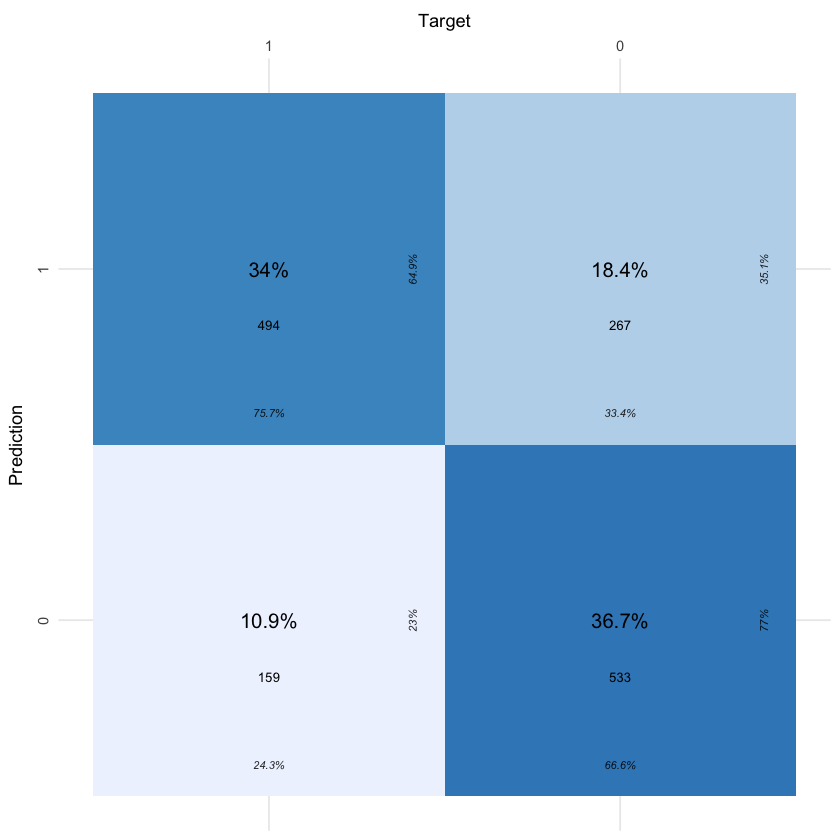

In [ ]:
C_mat_test=confusionMatrix(test_predict, test$cardio)
# Tibble for train data
tab_fin_test=as_tibble(C_mat_test$table)
colnames(tab_fin_test)=c("Target","Prediction","N")
# Confusion matrix for train data
plot_confusion_matrix(tab_fin_test)

The accuracy on test data is 73.63%, which is slightly higher than but still close to the accuracy in the logistic model on the test data i.e. 72.20%, which suggests that the logistic regression model and SVM are good models in solving this problem.

In addition, recall is 64.64%, precision is 77.78%, and F-measure is 0.706.**

**3. Alternative evaluation model 1: decision tree**

Decision tree provides a tree-like graph which suggests the classification rules from the training set. These rules are used to predict the class labels for new unclassified observations in test data. Each node contains a splitting condition to separate the instances, and each leaf is given a class label.
* The result decision tree formed based on the training data is shown below.

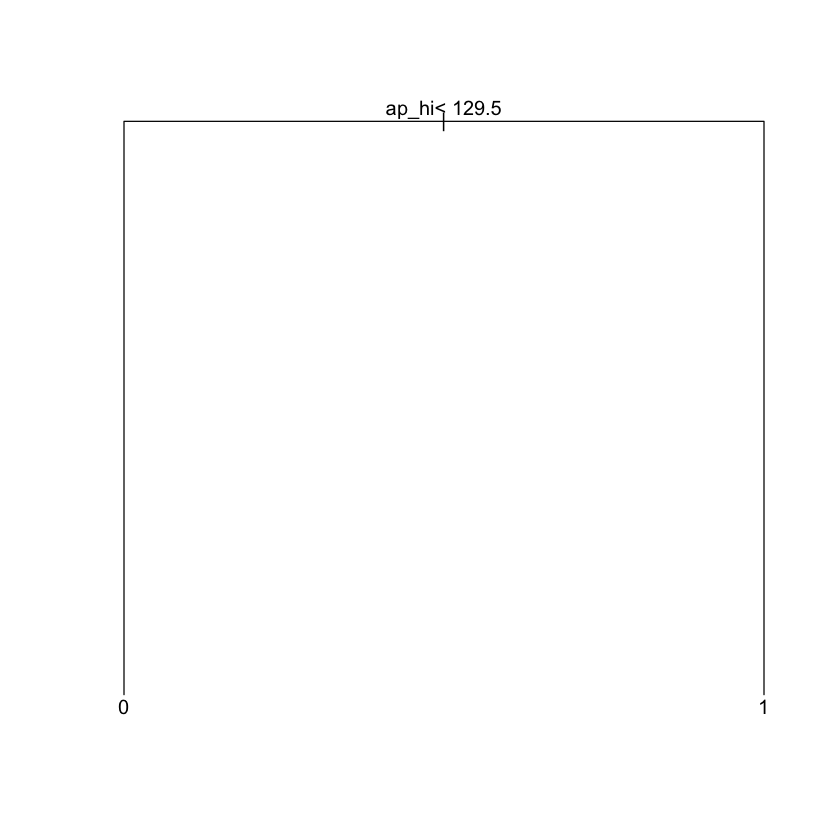

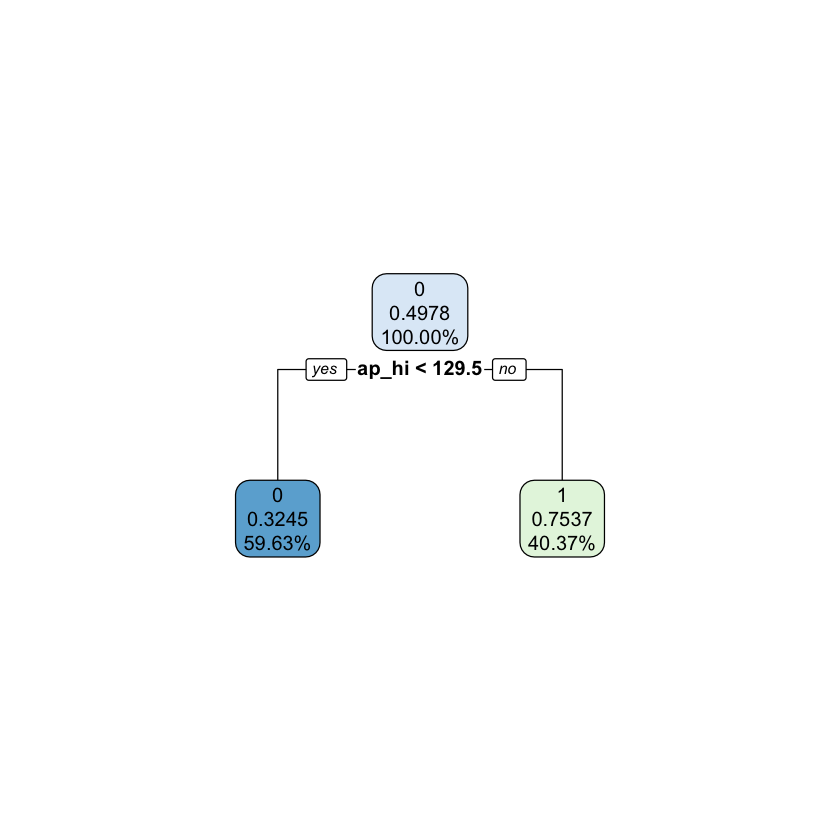

In [ ]:
fit1 <- rpart(cardio~age_y + gender + BMI + ap_hi + ap_lo + cholesterol + gluc + smoke + alco + active, data=train, method="class")
plot(fit1)
text(fit1)
rpart.plot(fit1, roundint = FALSE , digits = 4)

From the above decision tree chart, the training data is classified into 4 distinct groups based on classifiers: ap_hi and age. The way of interpreting the decision tree is to classify the new observations based on the values of the variables stated in the classification rules. For example, an individual who has systolic blood pressure below 126 (ap_hi < 126) with age below 53.91 years old (age < 53.91) is less likely to suffer from cardiovascular diseases. Another individual with systolic blood pressure above 126 (ap_hi > 126) is more likely to have cardiovascular diseases.

In [ ]:
prediction1 <- predict(fit1, test, type="class")
confusionMatrix(prediction1, test$cardio)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 547 275
         1 145 486
                                          
               Accuracy : 0.7109          
                 95% CI : (0.6869, 0.7342)
    No Information Rate : 0.5237          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4255          
                                          
 Mcnemar's Test P-Value : 3.083e-10       
                                          
            Sensitivity : 0.7905          
            Specificity : 0.6386          
         Pos Pred Value : 0.6655          
         Neg Pred Value : 0.7702          
             Prevalence : 0.4763          
         Detection Rate : 0.3765          
   Detection Prevalence : 0.5657          
      Balanced Accuracy : 0.7145          
                                          
       'Positive' Class : 0               
                              

Warning message in plot_confusion_matrix(tab_fin_train):
“'ggimage' is missing. Will not plot arrows and zero-shading.”
Warning message in plot_confusion_matrix(tab_fin_train):
“'rsvg' is missing. Will not plot arrows and zero-shading.”
Warning message:
“Ignoring unknown parameters: linewidth”


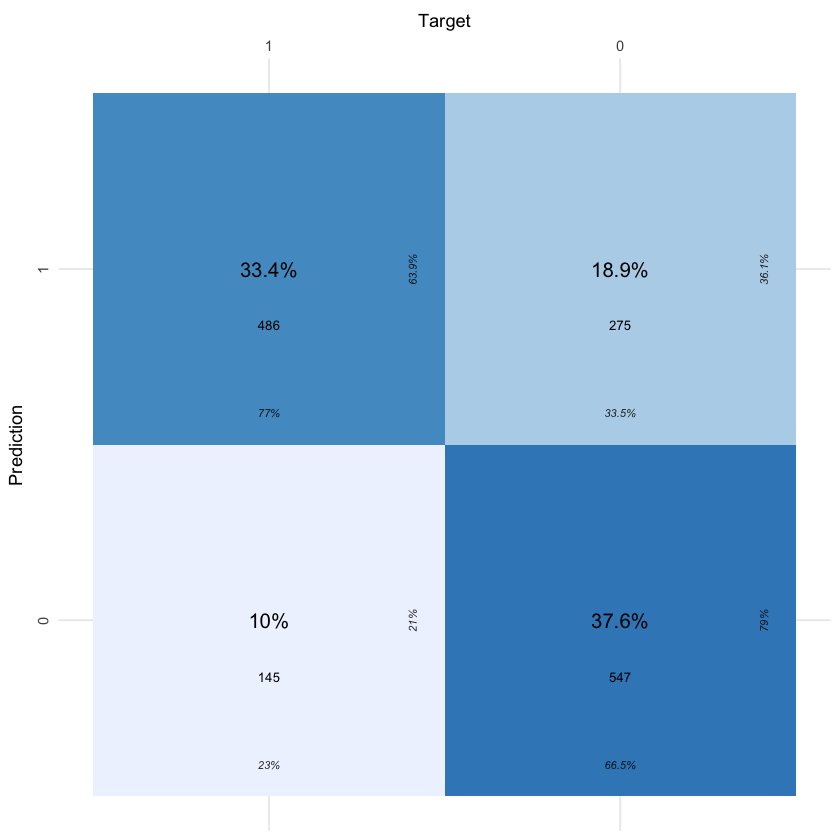

In [ ]:
C_mat_train=confusionMatrix(prediction1, test$cardio)
# Tibble for train data
tab_fin_train=as_tibble(C_mat_train$table)
colnames(tab_fin_train)=c("Target","Prediction","N")
# Confusion matrix for train data
plot_confusion_matrix(tab_fin_train)

The confusion matrix showing the performance of decision tree on test data is above.

The computed performance indicators are shown below. The accuracy when handling unseen test data is 70.52%, which is lower than the accuracy in the logistic model on the test data i.e. 72.20%. Besides, recall is 66.89%, precision is 71.21%, and F-measure is
0.6898.

**4. Alternative evaluation model 2: Naive Bayes**

Naive Bayes classifies observations based on posterior probability, prior probability and the conditional probability of test data. Also, it assumes that the value of a feature in a given class is independent of the values of other features. The confusion matrix showing the performance of decision tree on test data is below.

In [ ]:
NB <- naiveBayes(cardio ~ age_y + gender + BMI + ap_hi + ap_lo + cholesterol + gluc + smoke + alco + active, data = train)
train_predict <- predict(NB, train)
test_predict_nb <- predict(NB, test)
test_predict
cftrain <- confusionMatrix(train_predict, train$cardio)
cfm <- confusionMatrix(test_predict_nb, test$cardio)
cftrain
cfm

[1] 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1
  [38] 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0
  [75] 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0
 [112] 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0
 [149] 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1
 [186] 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0
 [223] 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0
 [260] 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 0
 [297] 1 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1
 [334] 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0
 [371] 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1
 [408] 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0
 [445] 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0
 [482] 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1
 [519] 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1
 [556] 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1
 [593] 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 1
 [630] 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1
 [667] 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1
 [704] 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1
 [741] 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0
 [778] 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1
 [815] 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 0
 [852] 0 1 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0
 [889] 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0
 [926] 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1
 [963] 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
[1000] 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1
[1037] 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1
[1074] 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1
[1111] 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1
[1148] 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0
[1185] 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1
[1222] 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1
[1259] 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1
[1296] 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0
[1333] 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0
[1370] 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1
[1407] 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1
[1444] 0 1 0 0 0 1 1 0 0 0
Levels: 0 1

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2851 1306
         1  655 2169
                                          
               Accuracy : 0.7191          
                 95% CI : (0.7084, 0.7296)
    No Information Rate : 0.5022          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4377          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8132          
            Specificity : 0.6242          
         Pos Pred Value : 0.6858          
         Neg Pred Value : 0.7681          
             Prevalence : 0.5022          
         Detection Rate : 0.4084          
   Detection Prevalence : 0.5955          
      Balanced Accuracy : 0.7187          
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 533 267
         1 159 494
                                          
               Accuracy : 0.7068          
                 95% CI : (0.6827, 0.7301)
    No Information Rate : 0.5237          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4164          
                                          
 Mcnemar's Test P-Value : 2.17e-07        
                                          
            Sensitivity : 0.7702          
            Specificity : 0.6491          
         Pos Pred Value : 0.6663          
         Neg Pred Value : 0.7565          
             Prevalence : 0.4763          
         Detection Rate : 0.3668          
   Detection Prevalence : 0.5506          
      Balanced Accuracy : 0.7097          
                                          
       'Positive' Class : 0               
                              

Warning message in plot_confusion_matrix(tab_fin_train):
“'ggimage' is missing. Will not plot arrows and zero-shading.”
Warning message in plot_confusion_matrix(tab_fin_train):
“'rsvg' is missing. Will not plot arrows and zero-shading.”
Warning message:
“Ignoring unknown parameters: linewidth”


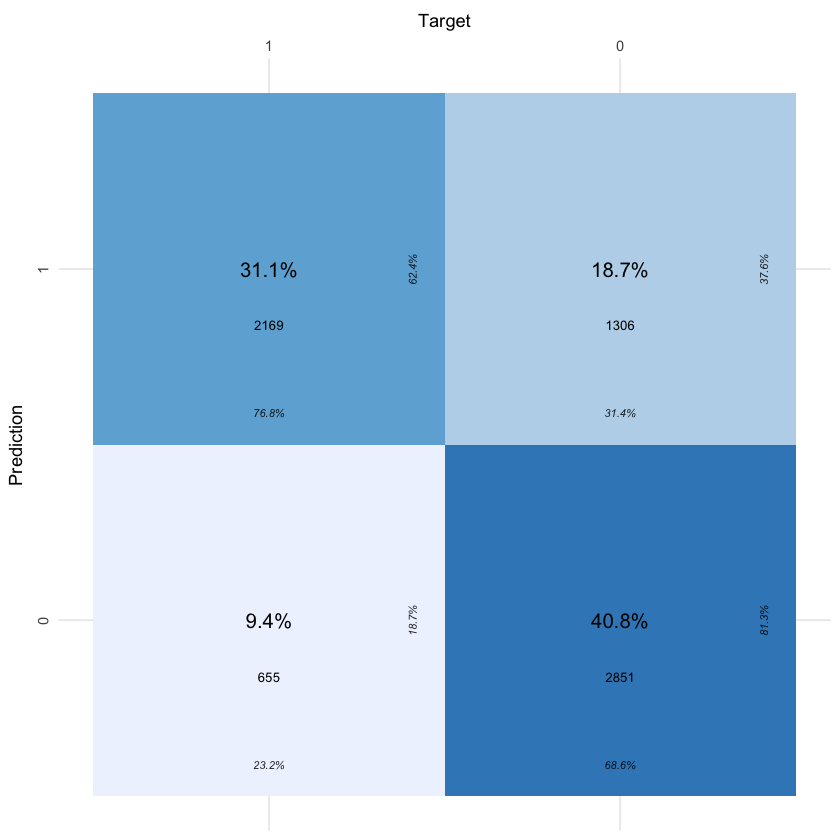

In [ ]:
C_mat_train=confusionMatrix(train_predict, train$cardio)
# Tibble for train data
tab_fin_train=as_tibble(C_mat_train$table)
colnames(tab_fin_train)=c("Target","Prediction","N")
# Confusion matrix for train data
plot_confusion_matrix(tab_fin_train)

Warning message in plot_confusion_matrix(tab_fin_test):
“'ggimage' is missing. Will not plot arrows and zero-shading.”
Warning message in plot_confusion_matrix(tab_fin_test):
“'rsvg' is missing. Will not plot arrows and zero-shading.”
Warning message:
“Ignoring unknown parameters: linewidth”


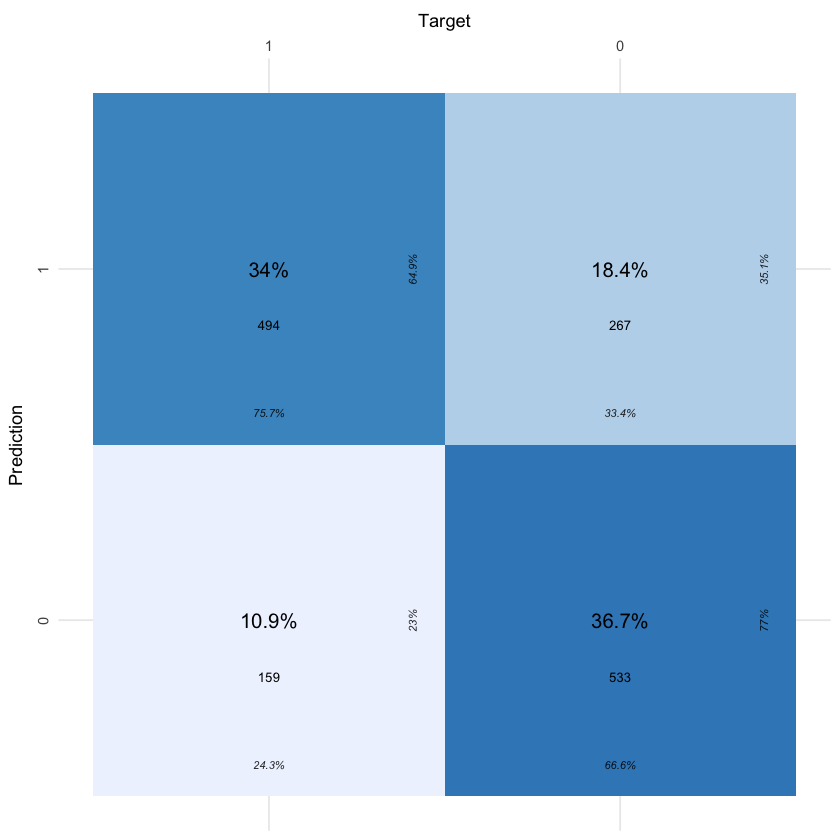

In [ ]:
C_mat_test=confusionMatrix(test_predict_nb, test$cardio)
# Tibble for train data
tab_fin_test=as_tibble(C_mat_test$table)
colnames(tab_fin_test)=c("Target","Prediction","N")
# Confusion matrix for train data
plot_confusion_matrix(tab_fin_test)

The computed performance indicators are shown below. The accuracy when handling unseen test data is 71.82%, which is lower than the accuracy in the logistic model on the test data i.e. 72.20%.